In [1]:
# Run the command below if necessary, for example with Google Colab
#!python3 -m pip install mxnet-cu117

In [2]:
# This recipe requires mxboard (which requires tensorboard)
#!python3 -m pip install tensorboard mxboard 

In [3]:
# Global Libraries
import collections
import gluoncv as gcv
import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
import os

# MXNet ND-Arrays with Numpy notation
# mx.npx.set_np()

# Local Libraries
import utils

# MxBoard SummaryWriter
from mxboard import SummaryWriter

# Logging
import logging
logging.basicConfig(level=logging.INFO)

# GPU mode
ctx = mx.gpu()

In [4]:
if not os.path.exists("cats_dogs_light.zip"):
    !wget https://zenodo.org/record/5226945/files/cats_dogs_light.zip?download=1 -O cats_dogs_light.zip

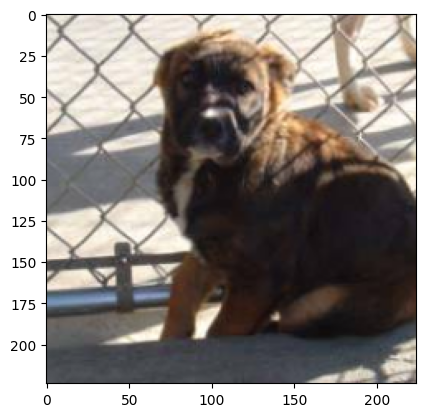

In [5]:
# Load Dataset: Dogs vs Cats Light Version
# Full dataset available: https://www.kaggle.com/c/dogs-vs-cats
# Light version available: https://zenodo.org/record/5226945#.Y9ZYCezP3VZ
from importlib import reload
reload(utils)

path = os.getcwd()

# Variables for dataset loading & pre-processing for plotting
imageNet = False
batch_size = 256

# Pre-processing the data, splitting training, validation and test set

# For Full Dataset (25k samples)
# Training set 20k samples (80%), Val set 2500 samples (10%), Test set 2500 samples (10%)
# light=False
# split = [0.8, 0.1, 0.1]

# For light version Dataset (1000 samples for Train+Val, 400 samples for Test)
# Training set 800 samples (80%), Val set 200 samples (20%), Test set 400 samples
light=True
split = [0.8, 0.2]

if not os.path.exists("./cats_dogs_light"):
    utils.preprocess_kaggle_cats_vs_dogs(path, split, light=light)

# Generate DataLoader without pre-processing for ImageNet for visualization purposes (light dataset version)
train_dataset, val_dataset, test_dataset = utils.generate_cats_vs_dogs_datasets(path, light=light, imageNet=imageNet)
train_dataldr, _, test_dataldr = utils.generate_cats_vs_dogs_dataloaders(train_dataset, None, test_dataset, batch_size=batch_size)

classes = ["Cats", "Dogs"]
classes_dict = utils.generate_class_dict_cats_vs_dogs_imagenet()

number_of_features = 224 * 224

# Plot image
batch_num = 0
index = 200
img_for_plot = test_dataset[batch_size * batch_num + index][0].asnumpy()
plt.imshow(img_for_plot)
plt.show()

In [6]:
# Variables for dataset loading & pre-processing for processing
imageNet = True
# Generate DataLoader without pre-processing for ImageNet for visualization purposes (light dataset version)
train_dataset, val_dataset, test_dataset = utils.generate_cats_vs_dogs_datasets(path, light=light, imageNet=imageNet)
train_dataldr, _, test_dataldr = utils.generate_cats_vs_dogs_dataloaders(train_dataset, None, test_dataset, batch_size=batch_size)

img_for_board = test_dataset[batch_size * batch_num + index][0]

In [7]:
def rescale(x, x_min=None, x_max=None):
    if x_min is None:
        x_min = x.min().asscalar()
    if x_max is None:
        x_max = x.max().asscalar()
    return (x - x_min) / (x_max - x_min)


def rescale_per_image(x):
    assert x.ndim == 4
    x = x.copy()
    for i in range(x.shape[0]):
        min_val = x[i].min().asscalar()
        max_val = x[i].max().asscalar()
        x[i] = rescale(x[i], min_val, max_val)
    return x


In [8]:
# Some excerpts from https://github.com/reminisce/mxboard-demo
path = os.getcwd()

sw = SummaryWriter(logdir=os.path.join(path, "logs"))

summary_image = mx.nd.expand_dims(img_for_board, axis=0)
print(summary_image.shape)

# plot conv filter and output of resnet-152
weight = mx.nd.load("../../mxboard-demo/data/resnet_152_conv0_weight.param")[0]
out = mx.nd.Convolution(summary_image, weight=weight, kernel=weight.shape[2:], num_filter=weight.shape[0], no_bias=True)
out = out.transpose((1, 0, 2, 3))
sw.add_image(tag="resnet_152_conv0_weight", image=rescale_per_image(weight))
sw.add_image(tag="resnet_152_conv0_output", image=rescale_per_image(out))

sw.close()

INFO:mxboard.event_file_writer:successfully opened events file: /home/andreto/code/public/Deep-Learning-with-MXNet-Cookbook/ch07/logs/events.out.tfevents.1693161204.ip-10-132-1-41
INFO:mxboard.event_file_writer:wrote 1 event to disk
INFO:mxboard.event_file_writer:wrote 1 event to disk


(1, 3, 224, 224)


INFO:mxboard.event_file_writer:wrote 1 event to disk


In [9]:
# ResNet152 from Model Zoo (This downloads v2)
resnet152 = gcv.model_zoo.get_model("resnet152_v2", pretrained=True, ctx=ctx)

[18:33:25] ../src/base.cc:79: cuDNN lib mismatch: linked-against version 8600 != compiled-against version 8101.  Set MXNET_CUDNN_LIB_CHECKING=0 to quiet this warning.


In [10]:
resnet152.features(summary_image.as_in_context(ctx))

[18:33:28] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:96: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)



[[2.5350871e-04 2.8519407e-01 1.6196619e-03 ... 7.2884483e-05
  2.9618644e-07 7.8995163e-03]]
<NDArray 1x2048 @gpu(0)>